# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

In [389]:
!pip install --upgrade scikit-learn --quiet
!pip install phik --quiet

In [390]:
import pandas as pd
import phik
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
import numpy as np
import time

In [391]:
RANDOM_STATE = 42

## Подготовка данных

In [392]:
autos = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv')

In [393]:
autos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [394]:
autos.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


#### Промежуточный вывод <br>
Данные загружены. Есть пропуски, обработаем их в пайплайне.

### Обработка данных

In [395]:
# Разобьём даты на отдельные признаки (год, месяц, день)
autos['DateCrawled'] = pd.to_datetime(autos['DateCrawled'])
autos['DateCreated'] = pd.to_datetime(autos['DateCreated'])
autos['LastSeen'] = pd.to_datetime(autos['LastSeen'])

autos['DateCrawled_year'] = autos['DateCrawled'].dt.year
autos['DateCrawled_month'] = autos['DateCrawled'].dt.month
autos['DateCrawled_day'] = autos['DateCrawled'].dt.day

autos['DateCreated_year'] = autos['DateCreated'].dt.year
autos['DateCreated_month'] = autos['DateCreated'].dt.month
autos['DateCreated_day'] = autos['DateCreated'].dt.day

autos['LastSeen_year'] = autos['LastSeen'].dt.year
autos['LastSeen_month'] = autos['LastSeen'].dt.month
autos['LastSeen_day'] = autos['LastSeen'].dt.day

autos = autos.drop(['DateCrawled', 'DateCreated', 'LastSeen'], axis=1)
autos

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,...,PostalCode,DateCrawled_year,DateCrawled_month,DateCrawled_day,DateCreated_year,DateCreated_month,DateCreated_day,LastSeen_year,LastSeen_month,LastSeen_day
0,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,...,70435,2016,3,24,2016,3,24,2016,4,7
1,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,...,66954,2016,3,24,2016,3,24,2016,4,7
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,...,90480,2016,3,14,2016,3,14,2016,4,5
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,...,91074,2016,3,17,2016,3,17,2016,3,17
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,...,60437,2016,3,31,2016,3,31,2016,4,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,...,2694,2016,3,21,2016,3,21,2016,3,21
354365,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,...,39576,2016,3,14,2016,3,14,2016,4,6
354366,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,...,26135,2016,3,5,2016,3,5,2016,3,11
354367,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,...,87439,2016,3,19,2016,3,19,2016,4,7


In [396]:
# Полные дубликаты
print('Дубликатов в данных:', autos.duplicated().sum())

# Удалим полные дубликаты
autos = autos.drop_duplicates().reset_index(drop=True)

Дубликатов в данных: 6828


In [397]:
# Проверка на опечатки в названиях столбцов (категориальные признаки)

categorical_columns = autos.select_dtypes(include='object').columns

for column in autos[categorical_columns]:
    print(column, autos[column].unique())
    print("--------------------")

VehicleType [nan 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other']
--------------------
Gearbox ['manual' 'auto' nan]
--------------------
Model ['golf' nan 'grand' 'fabia' '3er' '2_reihe' 'other' 'c_max' '3_reihe'
 'passat' 'navara' 'ka' 'polo' 'twingo' 'a_klasse' 'scirocco' '5er'
 'meriva' 'arosa' 'c4' 'civic' 'transporter' 'punto' 'e_klasse' 'clio'
 'kadett' 'kangoo' 'corsa' 'one' 'fortwo' '1er' 'b_klasse' 'signum'
 'astra' 'a8' 'jetta' 'fiesta' 'c_klasse' 'micra' 'vito' 'sprinter' '156'
 'escort' 'forester' 'xc_reihe' 'scenic' 'a4' 'a1' 'insignia' 'combo'
 'focus' 'tt' 'a6' 'jazz' 'omega' 'slk' '7er' '80' '147' '100' 'z_reihe'
 'sportage' 'sorento' 'v40' 'ibiza' 'mustang' 'eos' 'touran' 'getz' 'a3'
 'almera' 'megane' 'lupo' 'r19' 'zafira' 'caddy' 'mondeo' 'cordoba' 'colt'
 'impreza' 'vectra' 'berlingo' 'tiguan' 'i_reihe' 'espace' 'sharan'
 '6_reihe' 'panda' 'up' 'seicento' 'ceed' '5_reihe' 'yeti' 'octavia' 'mii'
 'rx_reihe' '6er' 'modus' 'fox' 'matiz' 'beetle' 'c1'

#### Промежуточный вывод <br>
Опечаток нет. Признаки в порядке.

#### Анализ признаков

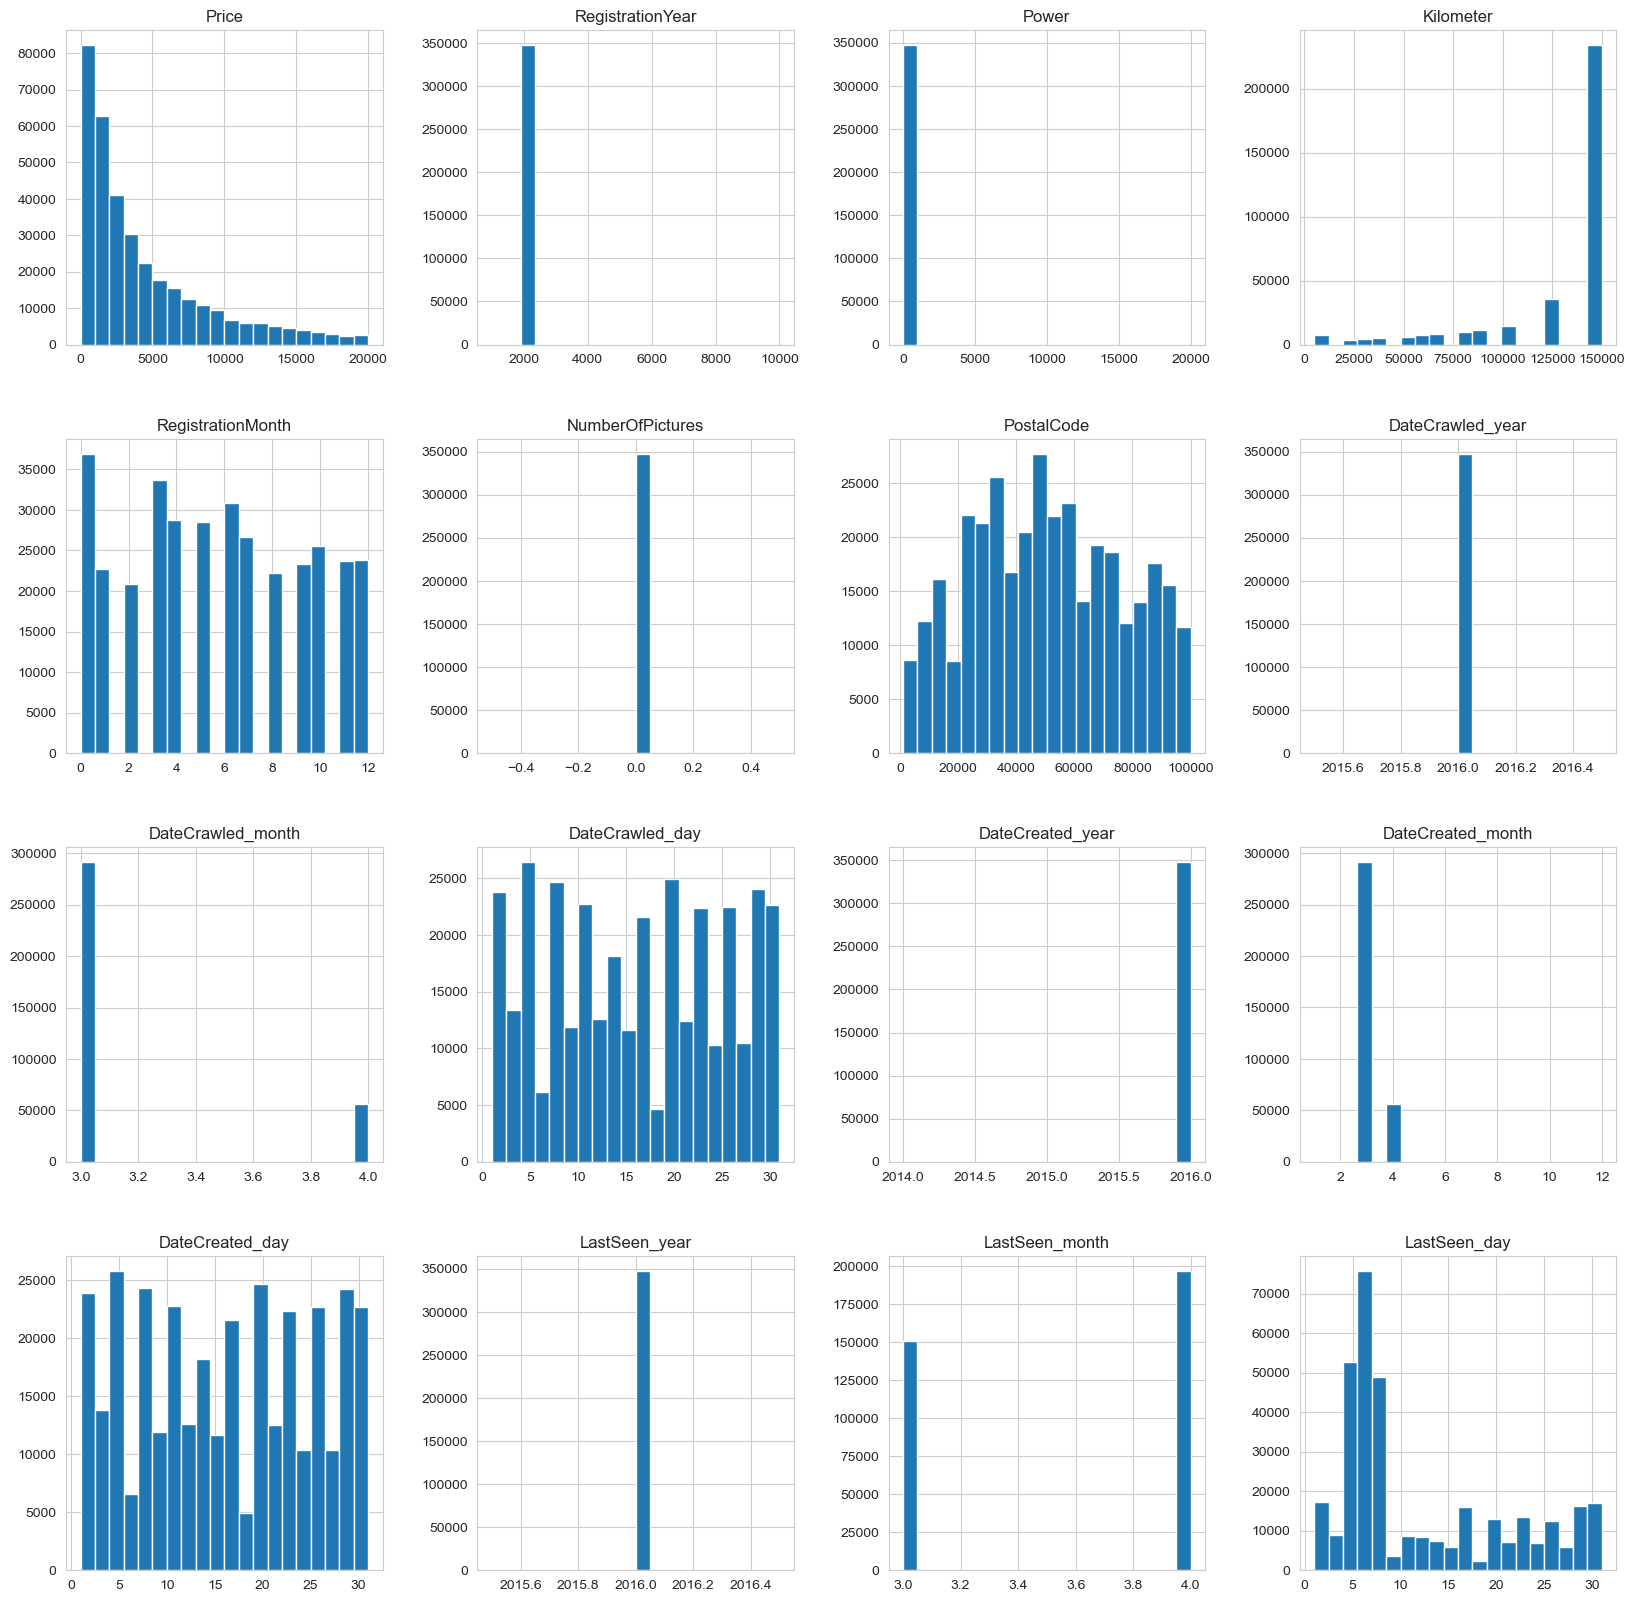

In [398]:
autos.hist(figsize=(20, 20), bins=20);

In [399]:
print(autos['NumberOfPictures'].value_counts())

autos = autos.drop('NumberOfPictures', axis=1)

NumberOfPictures
0    347541
Name: count, dtype: int64


In [400]:
autos = autos.drop('PostalCode', axis=1)

In [401]:
# Удалим выбросы в годах регистрации
autos = autos[(autos['RegistrationYear'] >= 1900) & (autos['RegistrationYear'] <= 2024)]

#### Промежуточный вывод <br>
NumberOfPictures - признак, который не несет информации. Удалим его. <br>
PostalCode - не влияет на стоимость автомобиля. Удалим его. <br>


### Матрица корреляции

In [402]:
autos.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCrawled_year,DateCrawled_month,DateCrawled_day,DateCreated_year,DateCreated_month,DateCreated_day,LastSeen_year,LastSeen_month,LastSeen_day
0,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016,3,24,2016,3,24,2016,4,7
1,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016,3,24,2016,3,24,2016,4,7
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016,3,14,2016,3,14,2016,4,5
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016,3,17,2016,3,17,2016,3,17
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016,3,31,2016,3,31,2016,4,6


In [403]:
corr_cols = ['Price', 'VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Model', 'Kilometer', 'FuelType', 'Brand', 'Repaired']
autos[corr_cols].phik_matrix()

interval columns not set, guessing: ['Price', 'RegistrationYear', 'Power', 'Kilometer']


/opt/miniconda3/lib/python3.12/site-packages/phik/phik.py:150: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_binned.replace(defs.UF, np.nan, inplace=True)


,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
Price,1.000000,0.267528,0.499608,0.321891,0.005345,0.578729,0.310372,0.256779,0.354975,0.380876
VehicleType,0.267528,1.000000,0.153327,0.287880,0.011686,0.916992,0.171743,0.330361,0.633888,0.084553
RegistrationYear,0.499608,0.153327,1.000000,0.075684,0.000000,0.568055,0.321591,0.192781,0.347777,0.145777
Gearbox,0.321891,0.287880,0.075684,1.000000,0.010682,0.646247,0.017781,0.150130,0.520281,0.043933
Power,0.005345,0.011686,0.000000,0.010682,1.000000,0.000000,0.000000,0.010787,0.006021,0.010566
Model,0.578729,0.916992,0.568055,0.646247,0.000000,1.000000,0.442190,0.555801,0.998368,0.158818
Kilometer,0.310372,0.171743,0.321591,0.017781,0.000000,0.442190,1.000000,0.149741,0.274933,0.112683
FuelType,0.256779,0.330361,0.192781,0.150130,0.010787,0.555801,0.149741,1.000000,0.323156,0.044536
Brand,0.354975,0.633888,0.347777,0.520281,0.006021,0.998368,0.274933,0.323156,1.000000,0.105816
Repaired,0.380876,0.084553,0.145777,0.043933,0.010566,0.158818,0.112683,0.044536,0.105816,1.000000


Brand и Model имеют слишком высокую корреляцию. Удалим один из признаков.

In [404]:
autos = autos.drop('Model', axis=1)

## Обучение моделей

In [405]:
X = autos.drop('Price', axis=1)
y = autos['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE)

print('X_train:', X_train.shape)
print('y_train:', y_train.shape)

X_train: (260529, 18)
y_train: (260529,)


In [406]:
X_train.columns

Index(['VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Kilometer',
       'RegistrationMonth', 'FuelType', 'Brand', 'Repaired',
       'DateCrawled_year', 'DateCrawled_month', 'DateCrawled_day',
       'DateCreated_year', 'DateCreated_month', 'DateCreated_day',
       'LastSeen_year', 'LastSeen_month', 'LastSeen_day'],
      dtype='object')

In [407]:
binary_columns = ['Gearbox', 'Repaired']
ohe_columns = ['VehicleType', 'FuelType', 'Brand']
num_columns = [
    'RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth',
    'DateCrawled_year', 'DateCrawled_month', 'DateCrawled_day',
    'DateCreated_year', 'DateCreated_month', 'DateCreated_day',
    'LastSeen_year', 'LastSeen_month', 'LastSeen_day'
]

In [408]:
binary_pipeline = Pipeline(steps=[
    ('imputer_before', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder()),
    ('imputer_after', SimpleImputer(strategy='most_frequent'))
])

categorical_pipeline = Pipeline(steps=[
    ('imputer_before', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)),
    ('imputer_after', SimpleImputer(strategy='most_frequent'))
])

numeric_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

In [409]:
data_preprocessor = ColumnTransformer(transformers=[
    ('binary', binary_pipeline, binary_columns),
    ('categorical', categorical_pipeline, ohe_columns),
    ('numeric', numeric_pipeline, num_columns)
])

In [410]:
def rmse_score(model, X, y):
    return np.abs(cross_val_score(model, X, y, cv=3, scoring='neg_root_mean_squared_error').mean())

### Линейная регрессия

In [411]:
lr_pipeline = Pipeline(steps=[
    ('preprocessor', data_preprocessor),
    ('model', LinearRegression())
])

start = time.time()
lr_pipeline.fit(X_train, y_train)
lr_time = time.time() - start

start_pred = time.time()
lr_pred = lr_pipeline.predict(X_test)
lr_pred_time = time.time() - start_pred

lr_rmse = rmse_score(lr_pipeline, X_train, y_train)

print('RMSE:', lr_rmse)
print('Время обучения:', lr_time, 'секунд')
print('Время предсказания:', lr_pred_time, 'секунд')

RMSE: 3168.321304614959
Время обучения: 1.6087543964385986 секунд
Время предсказания: 0.12947821617126465 секунд


### LightGBM

In [412]:
lgbm_pipeline = Pipeline(steps=[
    ('preprocessor', data_preprocessor),
    ('model', LGBMRegressor(verbose=0))
])

start = time.time()
lgbm_pipeline.fit(X_train, y_train)
lgbm_time = time.time() - start

start_pred = time.time()
lgbm_pred = lgbm_pipeline.predict(X_test)
lgbm_pred_time = time.time() - start_pred

lgbm_rmse = rmse_score(lgbm_pipeline, X_train, y_train)

print('RMSE:', lgbm_rmse)
print('Время обучения:', lgbm_time, 'секунд')
print('Время предсказания:', lgbm_pred_time, 'секунд')

RMSE: 1866.68049603632
Время обучения: 1.4146349430084229 секунд
Время предсказания: 0.22827863693237305 секунд


### CatBoost

In [413]:
cat_pipeline = Pipeline(steps=[
    ('preprocessor', data_preprocessor),
    ('model', CatBoostRegressor(verbose=0))
])

start = time.time()
cat_pipeline.fit(X_train, y_train)
cat_time = time.time() - start

start_pred = time.time()
cat_pred = cat_pipeline.predict(X_test)
cat_pred_time = time.time() - start_pred

cat_rmse = rmse_score(cat_pipeline, X_train, y_train)

print('RMSE:', cat_rmse)
print('Время обучения:', cat_time, 'секунд')
print('Время предсказания:', cat_pred_time, 'секунд')

RMSE: 1794.680553533688
Время обучения: 13.493759155273438 секунд
Время предсказания: 1.5618896484375 секунд


## Анализ моделей

### Промежуточный вывод <br>
Лучший результат показала модель CatBoost. Метрика RMSE: 1795. Время обучения: 14 секунд.
1. CatBoost: RMSE - 1794, время обучения - 17.3 секунд, время предсказания - 1.56 секунды
2. LightGBM: RMSE - 1866, время обучения - 1.6 секунды, время предсказания - 0.2 секунды
3. Линейная регрессия: RMSE - 3168, время обучения - 2.34 секунды, время предсказания - 0.13 секунды

## Вывод
Лучший баланс между временем предсказания и точностью модели показала модель LightGBM. <br>
RMSE - 1866, время обучения - 1.6 секунды, время предсказания - 0.2 секунды. <br>
Эта модель сильно быстрее CatBoost и точнее Линейной регрессии.

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Выполнена загрузка и подготовка данных
- [ ]  Выполнено обучение моделей
- [ ]  Есть анализ скорости работы и качества моделей